In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
down_root = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
housing_path = "datasets/housing"
housing_url = down_root + housing_path + "/housing.tgz"

In [3]:
print(housing_url)

https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz


In [4]:
def fetch_housing_data(hurl = housing_url, hpath = housing_path):
    if not os.path.isdir(hpath):
        os.makedirs(hpath)
    tgz_path = os.path.join(hpath,"housing.tgz")
    urllib.request.urlretrieve(hurl,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=hpath)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd
def load_housing_data(hpath = housing_path):
    csv_path = os.path.join(hpath,"housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# # using sklearn techniques and dedicated function (NOT BEST)
# import numpy as np
# def split_train_test ( data , test_ratio ):
#     indices = np.random.permutation(len(data))
#     testsize = int(0.2*len(data))
#     test_indices = indices[:testsize]
#     train_indices = indices[testsize:]
#     return data.iloc[train_indices],data.iloc[test_indices]
# train_set, test_set = split_train_test(housing,0.2)
# from sklearn.model_selection import train_test_split
# train_set,test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

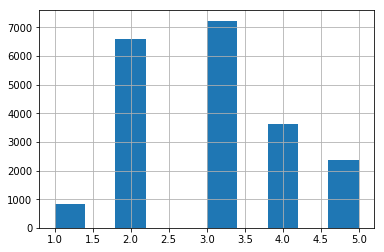

In [8]:
%matplotlib inline
import numpy as np
housing["income_cat"] = pd.cut(housing['median_income'],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()
housing["income_cat"].hist()

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(10,0.2,random_state=42)
for train_idx,test_idx in sss.split(housing,housing["income_cat"]):
    ss_train_set = housing.iloc[train_idx]
    ss_test_set = housing.iloc[test_idx]
ss_test_set["income_cat"].value_counts()/len(ss_test_set) #percentage of a category in a dataset

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [10]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [11]:
for set_ in (ss_train_set, ss_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
housing = ss_train_set.copy()

In [13]:
corr_mat = housing.corr()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16349.00000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.553467,35.619624,28.486676,2635.966388,538.12643,1422.971596,499.279857,3.868991,206838.327035
std,2.003684,2.138291,12.554158,2150.726896,415.60066,1128.464558,376.607586,1.896538,115349.090877
min,-124.350000,32.540000,1.000000,2.000000,1.00000,3.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.930000,18.000000,1453.000000,297.00000,789.000000,281.000000,2.566700,119675.000000
50%,-118.480000,34.250000,29.000000,2143.000000,436.00000,1169.000000,411.000000,3.529000,179700.000000
75%,-118.000000,37.710000,37.000000,3157.250000,650.00000,1728.000000,607.000000,4.746450,265300.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.00000,35682.000000,6082.000000,15.000100,500001.000000


In [14]:
#learning setup
housing = ss_train_set.drop('median_house_value',axis=1)
housing_labels = ss_train_set['median_house_value'].copy()

# CREATION OF CUSTOM TRANSFORMERS

In [15]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]
from sklearn.base import BaseEstimator,TransformerMixin
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [16]:
# from sklearn.base import BaseEstimator, TransformerMixin
# class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
#     def __init__(self, add_bedrooms_per_room = True):
#         self.add_bedrooms_per_room = add_bedrooms_per_room
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X, y=None):
#         rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
#         population_per_household = X[:,population_ix]/X[:,households_ix]
#         if self.add_bedrooms_per_room:
#             bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
#             return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
#         else:
#             return np.c_[X,rooms_per_household,population_per_household]

# CREATING SELECTOR TO CONVERT DF TO NUMPY ARRAYS

In [17]:
class DataFrameSelector(TransformerMixin,BaseEstimator):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [18]:
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

# CREATING PIPELINES

In [19]:
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.preprocessing import StandardScaler,Imputer
num_housing = housing.drop('ocean_proximity',axis=1)
num_attribs = list(num_housing)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ("selector",DataFrameSelector(num_attribs)),
    ("imputer",Imputer(strategy="median")),
    ("attribs_adder",CombinedAttributesAdder(add_bedrooms_per_room=False)),
    ("std_scaler",StandardScaler()),
])
cat_pipeline = Pipeline([
    ("selector",DataFrameSelector(cat_attribs)),
    ("label_binarizer",MyLabelBinarizer()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline),
])

In [20]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 15)

# TRAINING USING LINEAR REGRESSION

In [21]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [278151.68039515 140963.18426504 214397.1922801  268128.62113471
  51803.20825971]
Labels: [286900.0, 176600.0, 160700.0, 230900.0, 95800.0]


# ERROR CALCULATION

In [23]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68508.96972474198

In [24]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49754.80577753383

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# CROSS VALIDATION

In [26]:
# tree reg
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ",scores.mean())
    print("Standard Deviation: ",scores.std())
display_scores(tree_rmse_scores)

Scores:  [74463.17570854 70907.68009642 75612.56504795 66602.73963488
 72781.97668228 70482.65485075 68700.84678986 69645.60525512
 68996.36046581 69326.45341677]
Mean:  70752.00579483897
Standard Deviation:  2633.963928997109


In [27]:
#linear reg
scores = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores:  [73243.24323871 70475.41716597 69701.02757902 65896.51843722
 68938.22000381 67854.08730504 69263.62005937 65755.73913754
 66947.81296614 69123.99175517]
Mean:  68719.96776480018
Standard Deviation:  2136.8043493763607


In [28]:
#random forest reg
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
scores = cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores:  [55908.59529516 54515.78394361 53787.07416856 48550.34546665
 53188.20783521 52363.9760475  53394.11393352 50281.93383671
 52766.10849607 53412.46636926]
Mean:  52816.8605392278
Standard Deviation:  1976.0827413389732


# GRIDSEARCHCV

In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'n_estimators':[3,10,30]
        ,'max_features':[2,4,6,8]
    }
    ,{
        'bootstrap':[False]
        ,'n_estimators':[3,10]
        ,'max_features':[2,3,4]
    }
]
f_reg_gs = RandomForestRegressor()
gridsearch = GridSearchCV(f_reg_gs,param_grid,cv=5,scoring='neg_mean_squared_error')
gridsearch.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [31]:
print("best params: ",gridsearch.best_params_,"\n\n\n")
print("best estimator: ",gridsearch.best_estimator_,"\n\n\n")
cvres = gridsearch.cv_results_
for mean_score,params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params,"\n")

best params:  {'n_estimators': 30, 'max_features': 6} 



best estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) 



63643.59577379584 {'n_estimators': 3, 'max_features': 2} 

54680.312356537484 {'n_estimators': 10, 'max_features': 2} 

51830.3503582552 {'n_estimators': 30, 'max_features': 2} 

59896.29240774783 {'n_estimators': 3, 'max_features': 4} 

51885.66352396589 {'n_estimators': 10, 'max_features': 4} 

49741.478299607574 {'n_estimators': 30, 'max_features': 4} 

59836.065786393956 {'n_estimators': 3, 'max_features': 6} 

51613.321711463825 {'n_estimators': 10, 'max_features': 6} 

49462.78392288489 {'n_estimators': 30, 'max_features': 6} 

587

# RELEVANCE OF ATTRIBUTES

In [51]:
# from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# encoder = LabelEncoder()
# housingcatenc = encoder.fit_transform(['ocean_proximity'])
# encoder = OneHotEncoder()
# housingcat1hot = encoder.fit_transform(housingcatenc.reshape(-1,1))
# encoder.get_feature_names()

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

# RUNNING ON TEST

In [53]:
finmodel = gridsearch.best_estimator_
X_test = ss_test_set.drop( "median_house_value",axis = 1)
y_test = ss_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
preds = finmodel.predict(X_test_prepared)
finmse = mean_squared_error(y_test,preds)
finrmse = np.sqrt(finmse)
print(finrmse)

48873.20908109959
